In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122).

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq0.png?raw=1)

Cвёрточный слой использует *фильтры*. Эти фильтры имеют *ширину* (а также *высоту* в изображениях, но обычно не для текстов). Если фильтр имеет ширину 3, он может видеть 3 последовательных токена. Каждый свёрточный слой имеет множество таких фильтров (1024 в этом разделе). Каждый фильтр будет скользить по последовательности от начала до конца, просматривая все 3 последовательных токена одновременно. Идея состоит в том, что каждый из этих 1024 фильтров научится извлекать из текста разные признаки. Результат этого извлечения признаков будет затем использоваться моделью — потенциально в качестве входных данных для другого свёрточного слоя. Затем всё это можно использовать для извлечения особенностей из исходного предложения для перевода его на целевой язык.

In [2]:
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-15 18:37:47--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2023-05-15 18:37:48 (109 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
!pip install subword_nmt
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [4]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset

import spacy
import tqdm
import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
!pip install -U spacy==3.0
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 9.9 MB/s eta 0:00:00
  Using cached thinc-8.0.17-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (659 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 6.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for spacy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1909 lines of output]
      Copied /tmp/pip-install-eecr2wq4/spacy_51563b762ff647f087a213ae128dd21d/setup.cfg -> /tmp/pip-install-eecr2wq4/spacy_51563b762ff647f087a213ae128dd21d/spacy/tests/package
      Copied /tmp/pip-install-eecr2wq4/spacy_51563b762ff647f087a213ae128dd21d/pyproject

In [7]:
spacy_de = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')
def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Кодировщик

Свёрточная модель sequence-to-sequence получает два вектора контекста для каждого токена во входном предложении. Итак, если бы в нашем входном предложении было 6 токенов, мы получили бы 12 контекстных векторов, по два на каждый токен.

Два вектора контекста на токен - это *преобразованный* вектор и *комбинированный* вектор. Преобразованный вектор - это результат прохождения каждого токена через несколько слоев. Комбинированный вектор получается в результате суммирования вектора, прошедшего свёрточные слои, и эмбеддинга этого токена. Оба они возвращаются кодером для использования декодером.

In [8]:
import torch.nn.functional as F

class ConvolutionEncoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 256):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        #src = [batch size, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [0, 1, 2, 3, ..., src len - 1]
        #pos = [batch size, src len]
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        embedded = self.dropout(tok_embedded + pos_embedded)
        #embedded = [batch size, src len, emb dim]
        conv_input = self.emb2hid(embedded)
        #conv_input = [batch size, src len, hid dim]
        conv_input = conv_input.permute(0, 2, 1) 
        #conv_input = [batch size, hid dim, src len]
        for i, conv in enumerate(self.convs):
            conved = conv(self.dropout(conv_input))
            #conved = [batch size, 2 * hid dim, src len]
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            #conved = [batch size, hid dim, src len]
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            #conved = [batch size, hid dim, src len]
            #set conv_input to conved for next loop iteration
            conv_input = conved
        conved = self.hid2emb(conved.permute(0, 2, 1))
        #conved = [batch size, src len, emb dim]
        combined = (conved + embedded) * self.scale
        #combined = [batch size, src len, emb dim]
        return conved, combined

Декодер принимает фактическое целевое предложение и пытается его предсказать. Эта модель прогнозирует все токены в целевом предложении параллельно. Нет последовательной обработки, то есть цикла декодирования. 

Декодер похож на кодировщик, с некоторыми изменениями как в основной модели, так и в свёрточных блоках внутри модели.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/convseq2seq3.png?raw=1)

In [9]:
class ConvolutionDecoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 256):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        #conved_emb = [batch size, trg len, emb dim]
        combined = (conved_emb + embedded) * self.scale
        #combined = [batch size, trg len, emb dim]
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        #energy = [batch size, trg len, src len]
        attention = F.softmax(energy, dim=2)
        #attention = [batch size, trg len, src len]
        attended_encoding = torch.matmul(attention, encoder_combined)
        #attended_encoding = [batch size, trg len, emd dim]
        attended_encoding = self.attn_emb2hid(attended_encoding)
        #attended_encoding = [batch size, trg len, hid dim]
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        #attended_combined = [batch size, hid dim, trg len]
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, trg len]
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        embedded = self.dropout(tok_embedded + pos_embedded)
        conv_input = self.emb2hid(embedded)
        #conv_input = [batch size, trg len, hid dim]
        conv_input = conv_input.permute(0, 2, 1) 
        #conv_input = [batch size, hid dim, trg len]
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
            conv_input = self.dropout(conv_input)
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
            conved = conv(padded_conv_input)
            #conved = [batch size, 2 * hid dim, trg len]
            conved = F.glu(conved, dim = 1)
            #conved = [batch size, hid dim, trg len]
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            #attention = [batch size, trg len, src len]
            conved = (conved + conv_input) * self.scale
            #conved = [batch size, hid dim, trg len]
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
        #conved = [batch size, trg len, emb dim] 
        output = self.fc_out(self.dropout(conved))
        #output = [batch size, trg len, output dim]
        return output, attention

Кодирование - вставляем исходную последовательность и получаем «вектор контекста». Однако здесь два вектора контекста на одно слово в исходной последовательности, `encoder_conved` и `encoder_combined`.

Поскольку декодирование выполняется параллельно, нам не нужен цикл декодирования. Вся целевая последовательность сразу вводится в декодер, а заполнение используется для обеспечения того, чтобы каждый свёрточный фильтр в декодере мог видеть только текущий и предыдущий токены в последовательности, когда он скользит по предложению.

In [10]:
class ConvolutionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
        encoder_conved, encoder_combined = self.encoder(src)
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        return output

In [11]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,            
            batch_first=True)


dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])


SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 64
HID_DIM = 128 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

enc = ConvolutionEncoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = ConvolutionDecoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model_two = ConvolutionSeq2Seq(enc, dec).to(device)
optimizer = optim.Adam(model_two.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Для всех моделей мы никогда не помещаем `<eos>` в декодер. В моделях RNN это объяснялось тем, что цикл декодера останавливается при достихении значения `<eos>` в качестве входа для декодера. В этой модели мы просто отрезаем токен `<eos>` от конца последовательности. Таким образом:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ обозначает фактический элемент целевой последовательности. Затем вводим это в модель, чтобы получить предсказанную последовательность, которая должна предсказывать токен `<eos>`:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ обозначает предсказанный элемент целевой последовательности. Затем вычисляем наши потери, используя исходный тензор `trg` с токеном `<sos> `, отрезанным спереди, оставляя токен `<eos> `:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

Затем рассчитываем потери и обновляем параметры.

In [14]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

# Цикл оценки такой же, как цикл обучения, только без вычислений градиента и обновления параметров.
def evaluate_model_two(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg)
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [15]:
# сколько времени занимает каждая эпоха
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

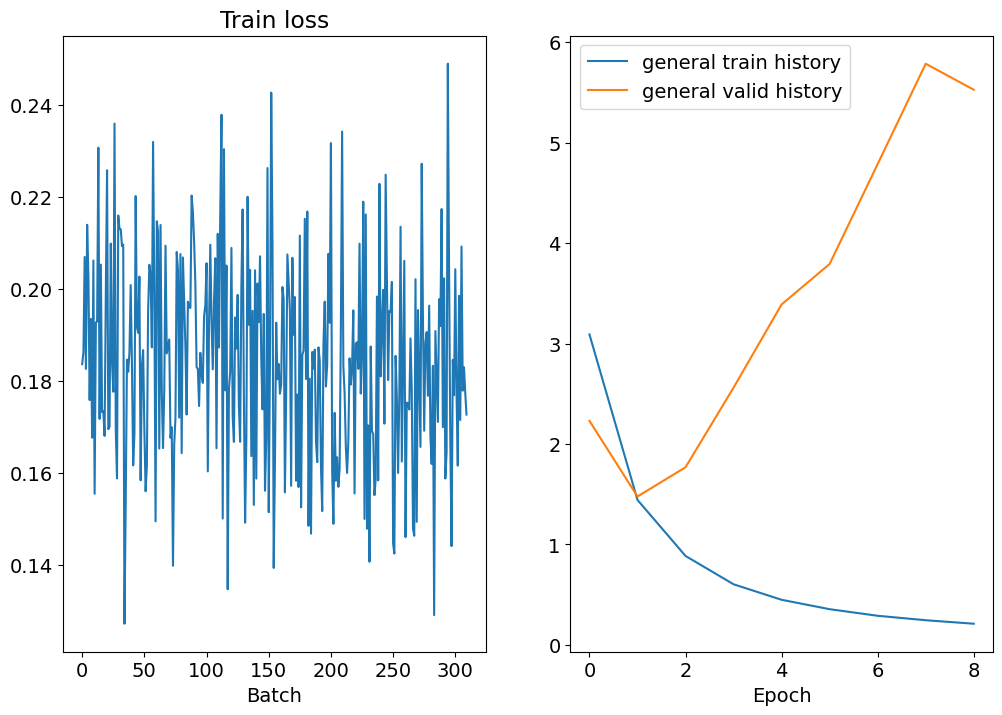

Epoch: 10 | Time: 0m 36s
	Train Loss: 0.184 | Train PPL:   1.202
	 Val. Loss: 6.392 |  Val. PPL: 596.857


In [16]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_two, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_model_two(model_two, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_two.state_dict(), 'conv-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [17]:
original_text = []
generated_text = []
model_two.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_two(src, trg) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:01, 56.56it/s]


In [18]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu([[text] for text in original_text], generated_text) * 100


25.563076172760073